In [17]:
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Balanceo
from imblearn.over_sampling import SMOTE

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Guardar modelo
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [18]:
# Cargar dataset
df = pd.read_csv("datos_tratados.csv")

print("Dimensiones:", df.shape)
display(df.head())

# Ver tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# Valores nulos
print("\nValores nulos:")
print(df.isnull().sum())

# Distribución de la variable objetivo
print("\nDistribución de abandono:")
print(df['abandono'].value_counts(normalize=True))

Dimensiones: (7256, 22)


,id_cliente,abandono,genero,adulto_mayor,pareja,dependientes,antiguedad_meses,servicio_telefonico,lineas_multiples,servicio_internet,...,proteccion_dispositivo,soporte_tecnico,streaming_tv,streaming_peliculas,cargo_mensual,cargo_total,contrato,facturacion_electronica,metodo_pago,cargo_diario
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,0,1,1,0,65.6,593.30,One year,1,Mailed check,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,1,59.9,542.40,Month-to-month,0,Mailed check,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,73.9,280.85,Month-to-month,1,Electronic check,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,0,1,1,98.0,1237.85,Month-to-month,1,Electronic check,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,1,1,0,83.9,267.40,Month-to-month,1,Mailed check,2.796667



Tipos de datos:
id_cliente                  object
abandono                     int64
genero                      object
adulto_mayor                 int64
pareja                       int64
dependientes                 int64
antiguedad_meses             int64
servicio_telefonico          int64
lineas_multiples             int64
servicio_internet           object
seguridad_en_linea           int64
respaldo_en_linea            int64
proteccion_dispositivo       int64
soporte_tecnico              int64
streaming_tv                 int64
streaming_peliculas          int64
cargo_mensual              float64
cargo_total                float64
contrato                    object
facturacion_electronica      int64
metodo_pago                 object
cargo_diario               float64
dtype: object

Valores nulos:
id_cliente                 0
abandono                   0
genero                     0
adulto_mayor               0
pareja                     0
dependientes               0
antigueda

In [19]:
# Eliminar id_cliente porque no aporta información predictiva
df = df.drop(columns=['id_cliente'])

# Identificar variables categóricas
cat_features = ['genero', 'servicio_internet', 'contrato', 'metodo_pago']
num_features = [col for col in df.columns if col not in cat_features + ['abandono']]

# Separar X e y
X = df.drop(columns=['abandono'])
y = df['abandono']

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [20]:
# Balanceo con SMOTE
smote = SMOTE(random_state=42)

# Aplicar preprocesamiento antes de SMOTE
X_processed = preprocessor.fit_transform(X)

X_res, y_res = smote.fit_resample(X_processed, y)

print("Distribución tras SMOTE:")
print(y_res.value_counts())

Distribución tras SMOTE:
abandono
0    5387
1    5387
Name: count, dtype: int64


In [21]:
# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
print("Tamaño train:", X_train.shape, "Tamaño test:", X_test.shape)

Tamaño train: (8619, 24) Tamaño test: (2155, 24)


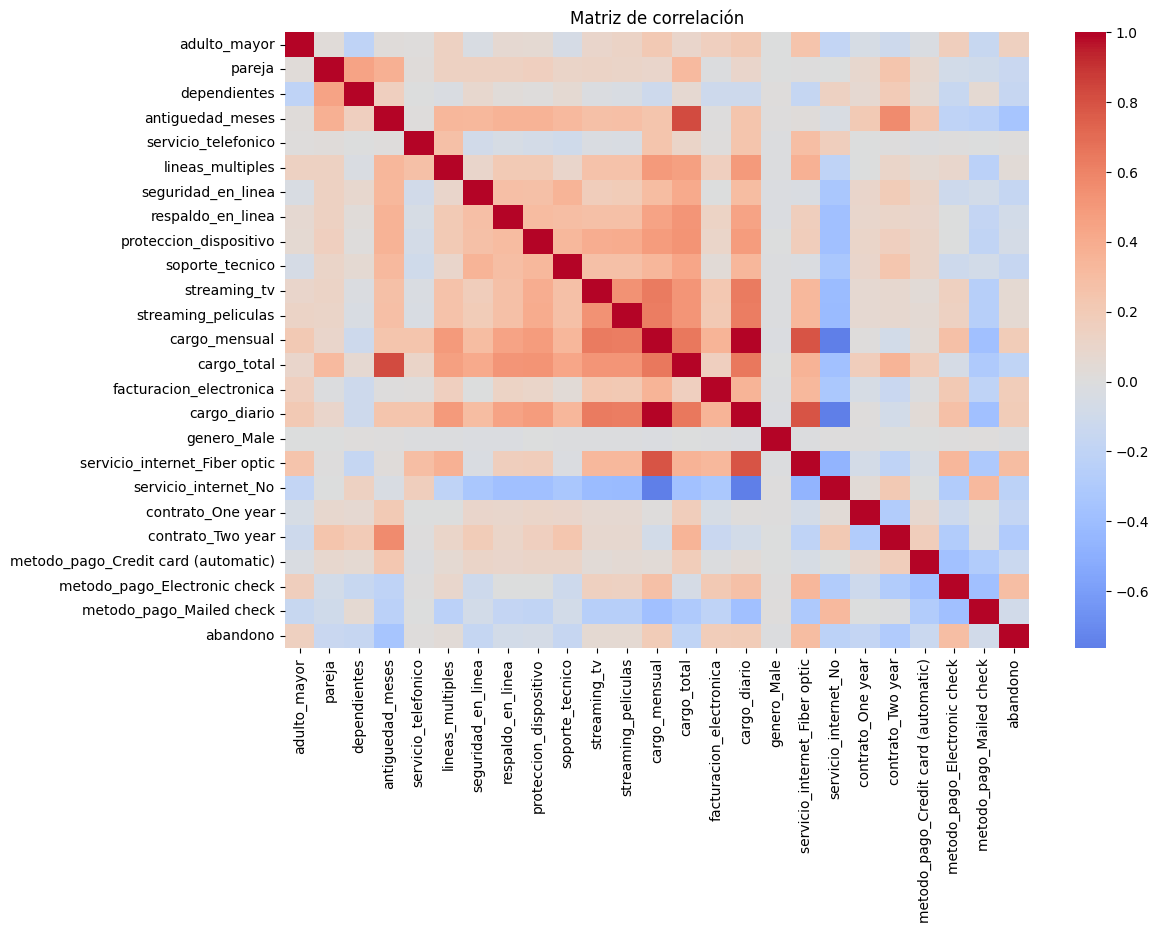

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,631.308491
1,adulto_mayor,1.155035
2,pareja,1.456650
3,dependientes,1.380301
4,antiguedad_meses,7.580478
5,servicio_telefonico,35.207218
6,lineas_multiples,7.317710
7,seguridad_en_linea,6.349251
8,respaldo_en_linea,6.825985
9,proteccion_dispositivo,6.953262


In [22]:
# Para calcular correlación necesitamos variables numéricas codificadas
df_encoded = pd.get_dummies(df.drop(columns=['abandono']), drop_first=True)
df_encoded['abandono'] = y

# Matriz de correlación
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', center=0)
plt.title("Matriz de correlación")
plt.show()

# VIF
X_vif = sm.add_constant(df_encoded.drop(columns=['abandono']))

# Convertir el DataFrame a tipo float para asegurar compatibilidad
X_vif_numeric = X_vif.astype(float)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_numeric.values, i) for i in range(X_vif_numeric.shape[1])]
display(vif_data)

In [23]:
# Definir modelos
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, model in models.items():

    clf = Pipeline(steps=[('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    results[name] = {
        "report": classification_report(y_test, y_pred, output_dict=True),
        "auc": auc
    }
    print(f"\nModelo: {name}")
    print(classification_report(y_test, y_pred))
    print("AUC:", auc)


Modelo: Decision Tree
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1078
           1       0.79      0.81      0.80      1077

    accuracy                           0.80      2155
   macro avg       0.80      0.80      0.80      2155
weighted avg       0.80      0.80      0.80      2155

AUC: 0.797686661395376

Modelo: Random Forest
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1078
           1       0.84      0.87      0.86      1077

    accuracy                           0.85      2155
   macro avg       0.85      0.85      0.85      2155
weighted avg       0.85      0.85      0.85      2155

AUC: 0.8533737121082923

Modelo: KNN
              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1078
           1       0.73      0.91      0.81      1077

    accuracy                           0.78      2155
   macro avg       0.8

In [24]:
# Comparar métricas principales
summary = pd.DataFrame({
    model: {
        "Precision": results[model]["report"]["1"]["precision"],
        "Recall": results[model]["report"]["1"]["recall"],
        "F1-score": results[model]["report"]["1"]["f1-score"],
        "AUC": results[model]["auc"]
    }
    for model in results
}).T

display(summary)

,Precision,Recall,F1-score,AUC
Decision Tree,0.788999,0.812442,0.800549,0.797687
Random Forest,0.839429,0.873723,0.856233,0.853374
KNN,0.726464,0.909935,0.807914,0.783817


from matplotlib import pyplot as plt
summary['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['F1-score'].plot(kind='hist', bins=20, title='F1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['AUC'].plot(kind='hist', bins=20, title='AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='Recall', y='F1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='F1-score', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['F1-score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('F1-score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['AUC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('AUC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
summary['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['F1-score'].plot(kind='line', figsize=(8, 4), title='F1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['AUC'].plot(kind='line', figsize=(8, 4), title='AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

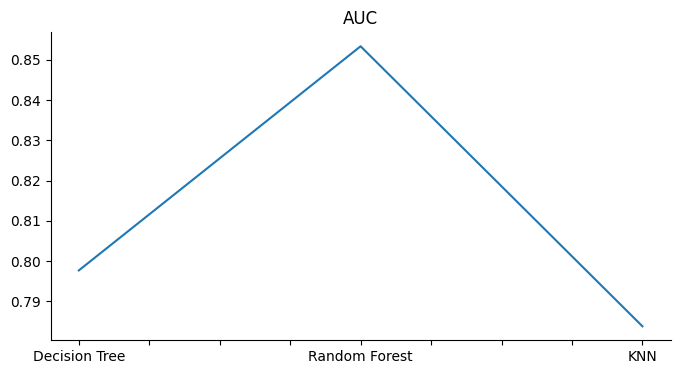

In [26]:
from matplotlib import pyplot as plt
summary['AUC'].plot(kind='line', figsize=(8, 4), title='AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

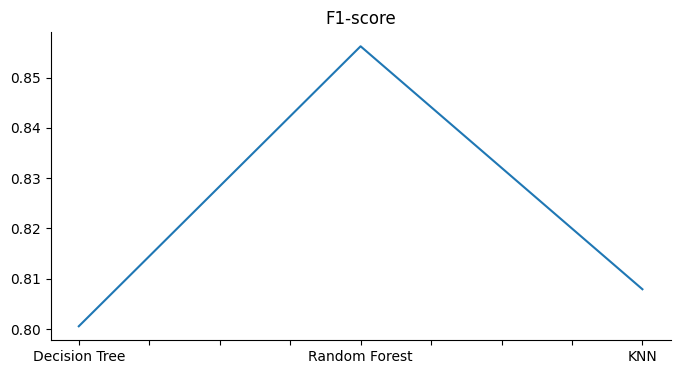

In [27]:
from matplotlib import pyplot as plt
summary['F1-score'].plot(kind='line', figsize=(8, 4), title='F1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

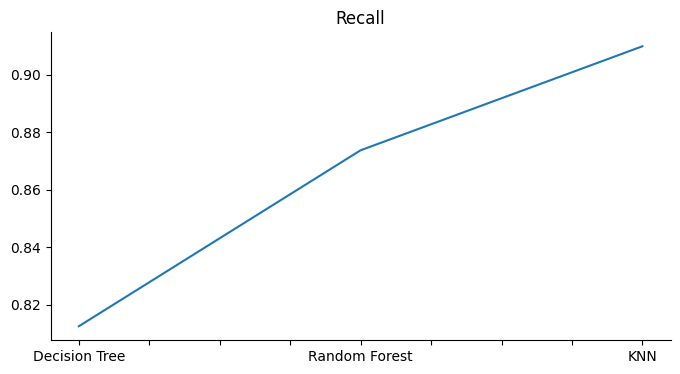

In [28]:
from matplotlib import pyplot as plt
summary['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

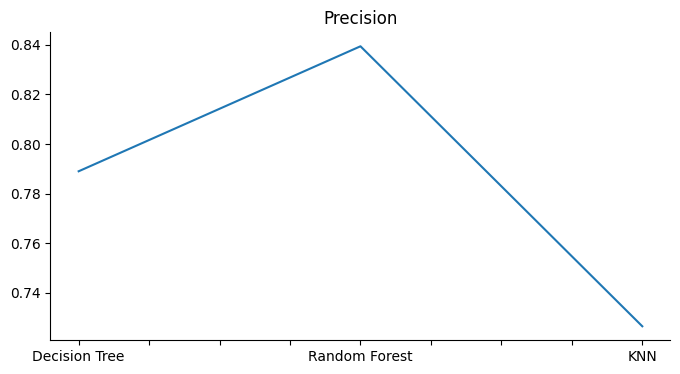

In [29]:
from matplotlib import pyplot as plt
summary['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

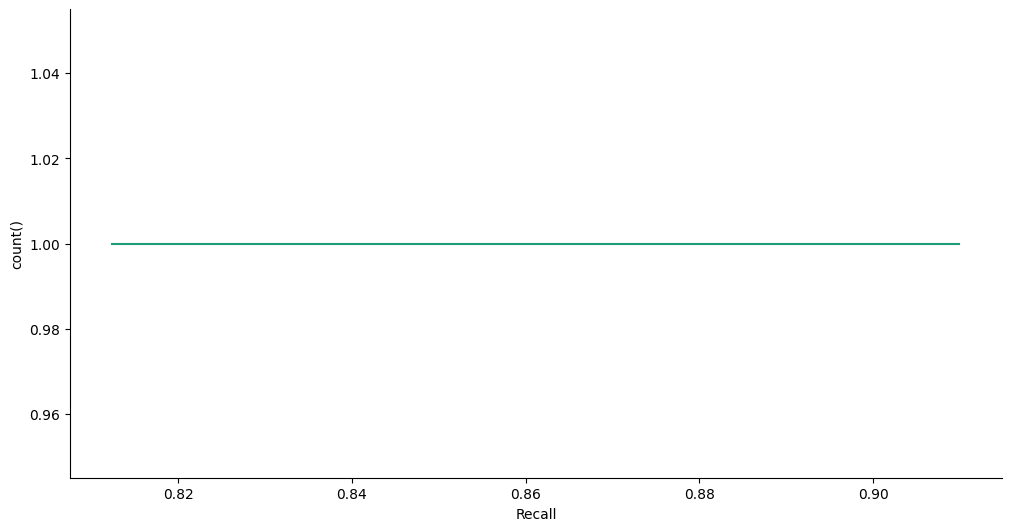

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

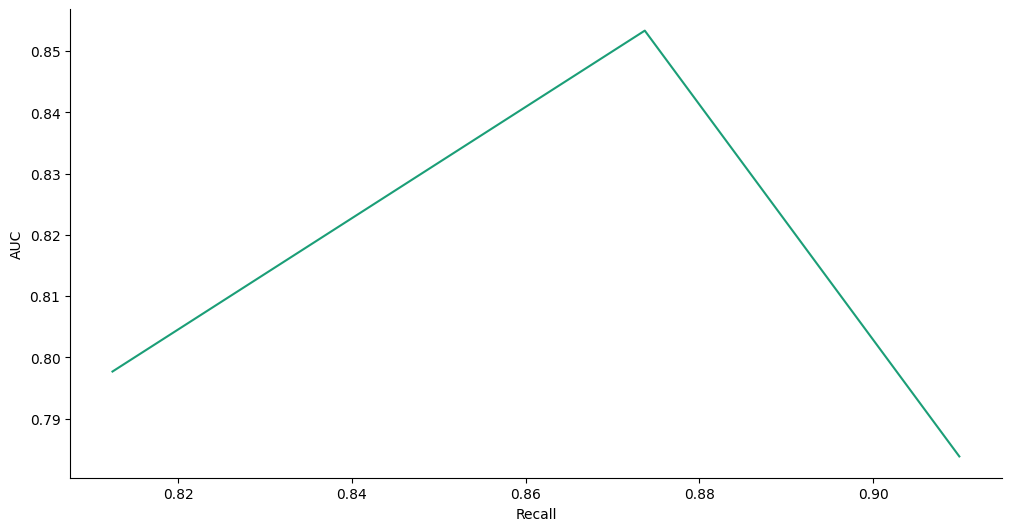

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['AUC']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('AUC')

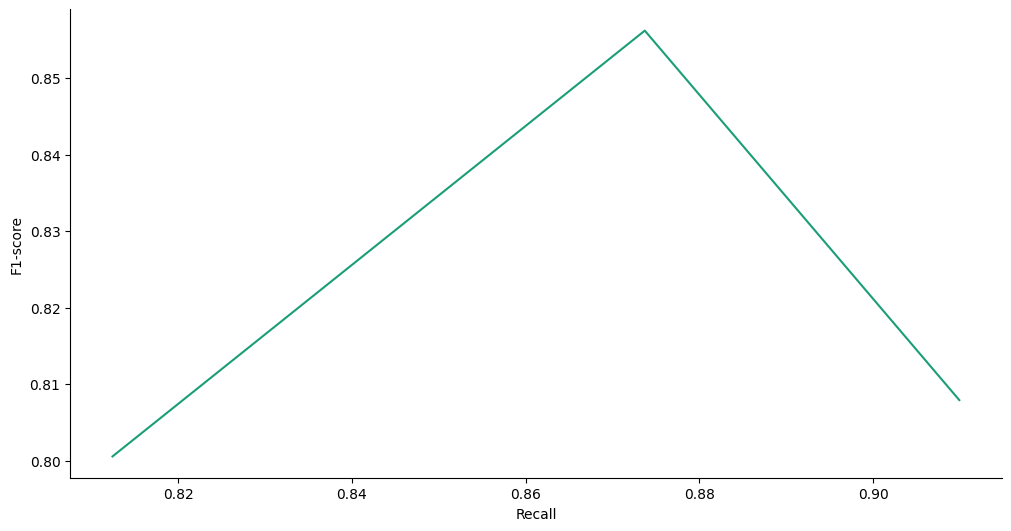

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['F1-score']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('F1-score')

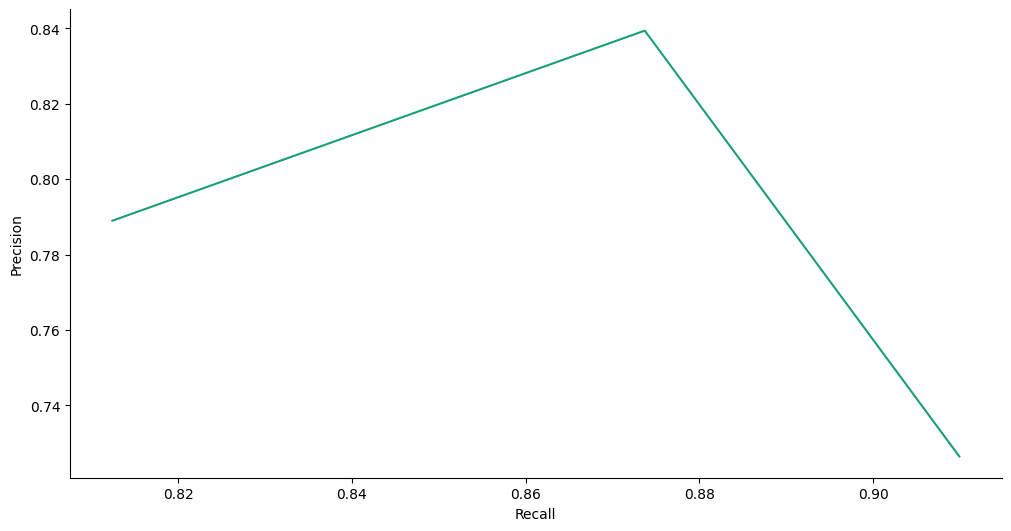

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['Precision']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('Precision')

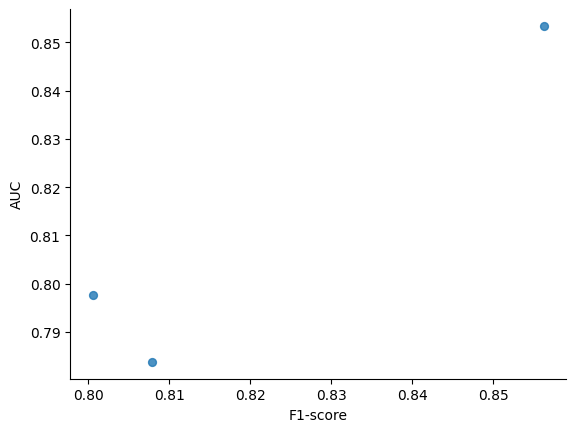

In [34]:
from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='F1-score', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

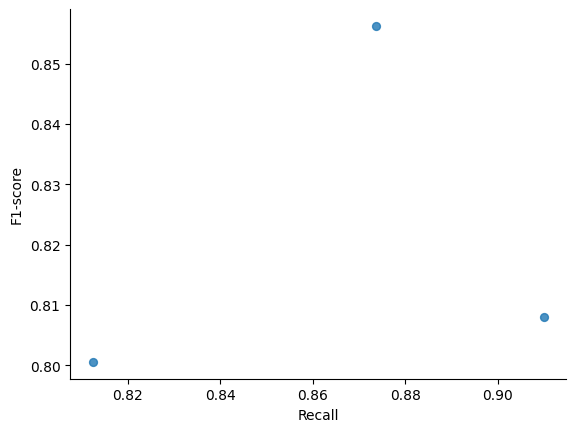

In [35]:
from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='Recall', y='F1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

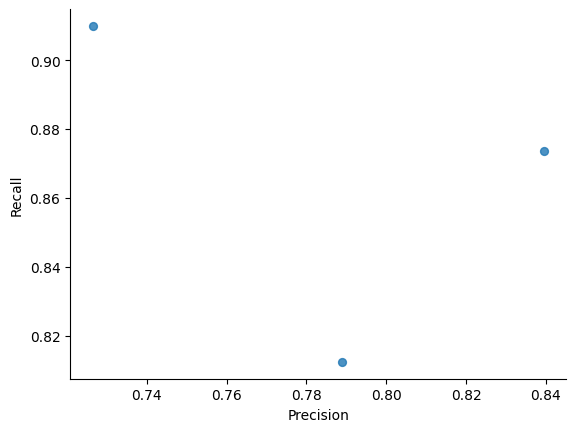

In [36]:
from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

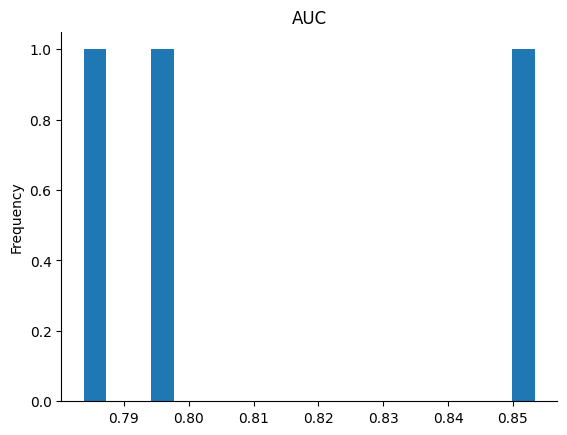

In [37]:
from matplotlib import pyplot as plt
summary['AUC'].plot(kind='hist', bins=20, title='AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

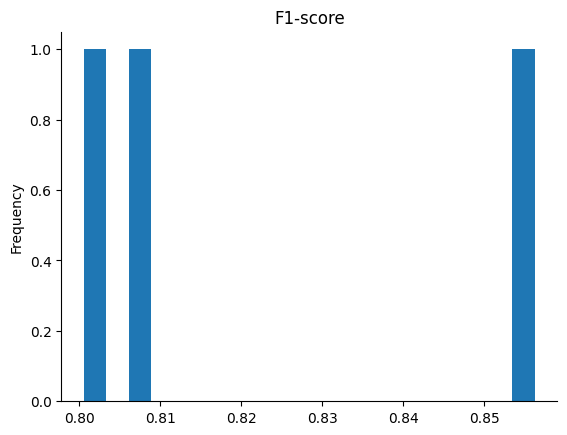

In [38]:
from matplotlib import pyplot as plt
summary['F1-score'].plot(kind='hist', bins=20, title='F1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

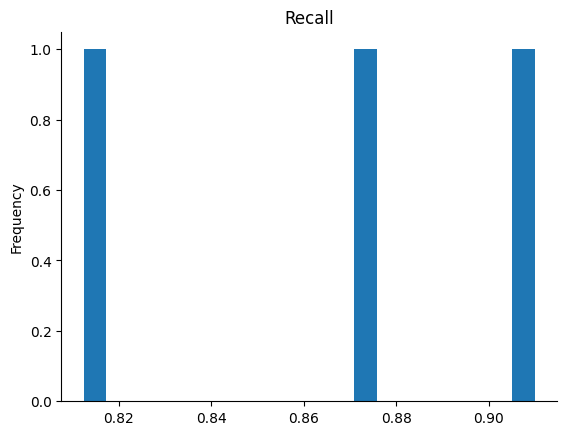

In [39]:
from matplotlib import pyplot as plt
summary['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

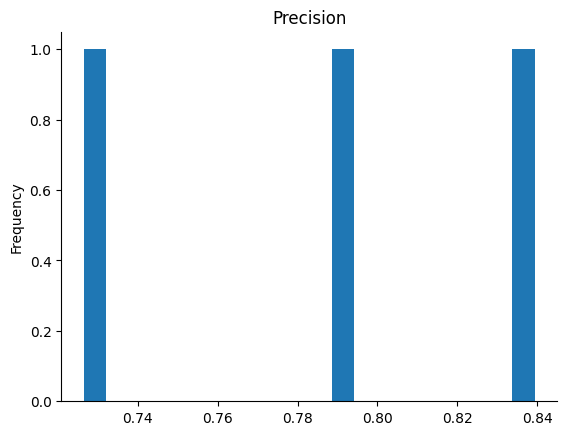

In [40]:
from matplotlib import pyplot as plt
summary['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [41]:
# Seleccionar mejor modelo por AUC
champion = max(results, key=lambda x: results[x]['auc'])
print("Modelo Champion:", champion)

# Entrenar de nuevo con todos los datos balanceados
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', models[champion])])
best_model.fit(X_res, y_res)

# Guardar modelo
joblib.dump(best_model, f"modelo_champion_{champion.replace(' ','_')}.pkl")
print("Modelo guardado exitosamente.")

Modelo Champion: Random Forest


ValueError: Specifying the columns using strings is only supported for dataframes.